# Feature selection

## Table of Contents
1. [ANOVA test for Feature selection](#chapter1)
2. [Filter Method for Feature Selection](#chapter2)
3. [Wrapper Method for Feature Selection](#chapter3)

We will perform feature selection on our dataset, because irrelavant features can:
- **Increase Model Complexity**: Because nnecessary features can lead to overfitting, where the model performs well on training data but poorly on unseen data.
- **Reduce Model Interpretability**: A large number of features makes it difficult to understand how the model arrives at its predictions.
- **Slow Down Training Time**: Training models with irrelevant features takes longer and consumes more computational resources.

Import required libraries

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from data_cleaning import get_Xy, med_impute, normalise, drop_high_corr

In [18]:
# Acess dataframe from EDA step
df_to_share = pd.read_pickle("df_to_share.pkl")
df_to_share.head()
df = df_to_share.copy()

In [19]:
def process0(df):
    X, y = get_Xy(df)
    X_imputed, y = med_impute(X, y)
    X_scaled_df = normalise(X_imputed)
    return X_scaled_df, y


# function to pre-process the data
def process1(df):
    X, y = get_Xy(df)
    X_imputed, y = med_impute(X, y)
    X_scaled_df = normalise(X_imputed)
    return drop_high_corr(X_scaled_df), y


# function to obtain train and test sets
def process2(df):
    X, y = process1(df)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=3244
    )

    return X_train, X_test, y_train, y_test


# function to obtain train and test sets with sythesised instances of the minority class
def pre_process(df):
    X, y = process1(df)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=3244
    )
    smote = SMOTE(random_state=3244)
    X_smote, y_train = smote.fit_resample(X_train, y_train)

    return X_smote, X_test, y_train, y_test


#### my functions
from data_cleaning import df_cleaning, df_preprocess_after_EDA


def preprocess(df):
    X, y = get_Xy(df)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=3244
    )
    return X_train, X_test, y_train, y_test


def preprocess_with_SMOTE(df):
    X, y = get_Xy(df)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=3244
    )
    smote = SMOTE(random_state=3244)
    X_smote, y_train = smote.fit_resample(X_train, y_train)
    return X_smote, X_test, y_train, y_test

## 1. ANOVA test for feature selection
**ANOVA (Analysis of Variance)** is a statistical test used in feature selection to identify features that have a significant influence on the target variable. 

Steps to select the best k features (where k is a chosen number):
- Focuses on Variance: ANOVA analyses the variation in a feature's values. It compares the variation between groups (bankrupt vs. non-bankrupt) to the variation within each group.
- Low p-value indicates Impact: Features with a low p-value (from the F-statistic) suggest a strong statistical difference in the feature's values between bankrupt and non-bankrupt companies. This implies the feature likely has a real impact on predicting bankruptcy.

In [20]:
def plot_ANOVA_test_graph(train_acc_dict, test_acc_dict):
    # Extract keys and values from train_acc_dict and test_acc_dict
    train_k_values, train_accuracy_values = zip(*train_acc_dict.items())
    test_k_values, test_accuracy_values = zip(*test_acc_dict.items())

    plt.figure(figsize=(6, 4))
    # Plot train accuracy
    plt.plot(
        train_k_values, train_accuracy_values, label="Train Accuracy", color="blue"
    )
    # Plot test accuracy
    plt.plot(test_k_values, test_accuracy_values, label="Test Accuracy", color="green")

    # Find k values corresponding to maximum accuracies
    best_train_k = max(train_acc_dict, key=train_acc_dict.get)
    best_test_k = max(test_acc_dict, key=test_acc_dict.get)
    best_train_accuracy = train_acc_dict[best_train_k]
    best_test_accuracy = test_acc_dict[best_test_k]

    # Annotate the point corresponding to the peak train accuracy
    plt.annotate(
        f"Max Train Accuracy\nk={best_train_k}, Acc={best_train_accuracy:.2f}",
        xy=(best_train_k, best_train_accuracy),
        xytext=(-30, 20),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="->", color="blue"),
    )

    # Annotate the point corresponding to the peak test accuracy
    plt.annotate(
        f"Max Test Accuracy\nk={best_test_k}, Acc={best_test_accuracy:.2f}",
        xy=(best_test_k, best_test_accuracy),
        xytext=(30, -30),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="->", color="green"),
    )

    # Label axes and add title
    plt.xlabel("Number of Features (k)")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs. Number of Features from ANOVA test")

    plt.legend()
    plt.show()


## Note: *args follow the convention X_train, X_test, y_train, y_test
def get_df_with_top_k_features(k_features, *args):  # after pre_process(df)
    X_train = args[0]
    X_test = args[1]
    y_train = args[2]
    y_test = args[3]

    # define feature selection
    fs = SelectKBest(score_func=f_classif, k=k_features)

    # apply feature selection
    fs.fit_transform(X_train, y_train)

    # Take the features with the highest F-scores
    fs_scores_array = np.array(fs.scores_)

    # Get the indices that would sort the array in descending order
    sorted_indices_desc = np.argsort(fs_scores_array)[::-1]

    # Take the top k indices
    top_indices = sorted_indices_desc[:k_features]

    selected_columns_X_train = X_train.iloc[:, top_indices]
    selected_columns_X_test = X_test.iloc[:, top_indices]

    return selected_columns_X_train, selected_columns_X_test, y_train, y_test


def find_best_k_features_from_ANOVA(model, *args):

    X_train = args[0]
    original_n_features = len(X_train.columns)

    train_acc_dict = {}  # 0 is a dummy accuracy for k=0 features
    test_acc_dict = {}
    train_test_dataset = {}

    for k in range(1, original_n_features + 1):
        print(f"k: {k}")
        train_test_dataset_after_ANOVA = get_df_with_top_k_features(k, *args)
        train_accuracy, test_accuracy = model(*train_test_dataset_after_ANOVA)
        train_test_dataset[k] = train_test_dataset_after_ANOVA
        train_acc_dict[k] = train_accuracy
        test_acc_dict[k] = test_accuracy

    # Find k that gives the highest accuracy
    best_train_k = max(train_acc_dict, key=train_acc_dict.get)
    best_test_k = max(test_acc_dict, key=test_acc_dict.get)

    print(f"\033[96mBest k for train_accuracy:\033[00m {best_train_k}")
    print(f"\033[96mBest k for test_accuracy:\033[00m {best_test_k}")

    plot_ANOVA_test_graph(train_acc_dict, test_acc_dict)

    return train_test_dataset[best_test_k]

### Using ANOVA test on our dataset

In [21]:
from sklearn.svm import SVC

train_test_dataset = preprocess(df)
train_test_smote_dataset = preprocess_with_SMOTE(df)

# Example of using the function
svm_model = SVC(kernel="sigmoid")
best_k = find_best_k_features_from_ANOVA(svm_model, train_test_dataset)
best_k_smote = find_best_k_features_from_ANOVA(svm_model, train_test_smote_dataset)
best_k
best_k_smote

AttributeError: 'tuple' object has no attribute 'columns'

Moving forward, we can use ANOVA test for feature selection to reduce the number of features in our dataset before building our model.

<Axes: >

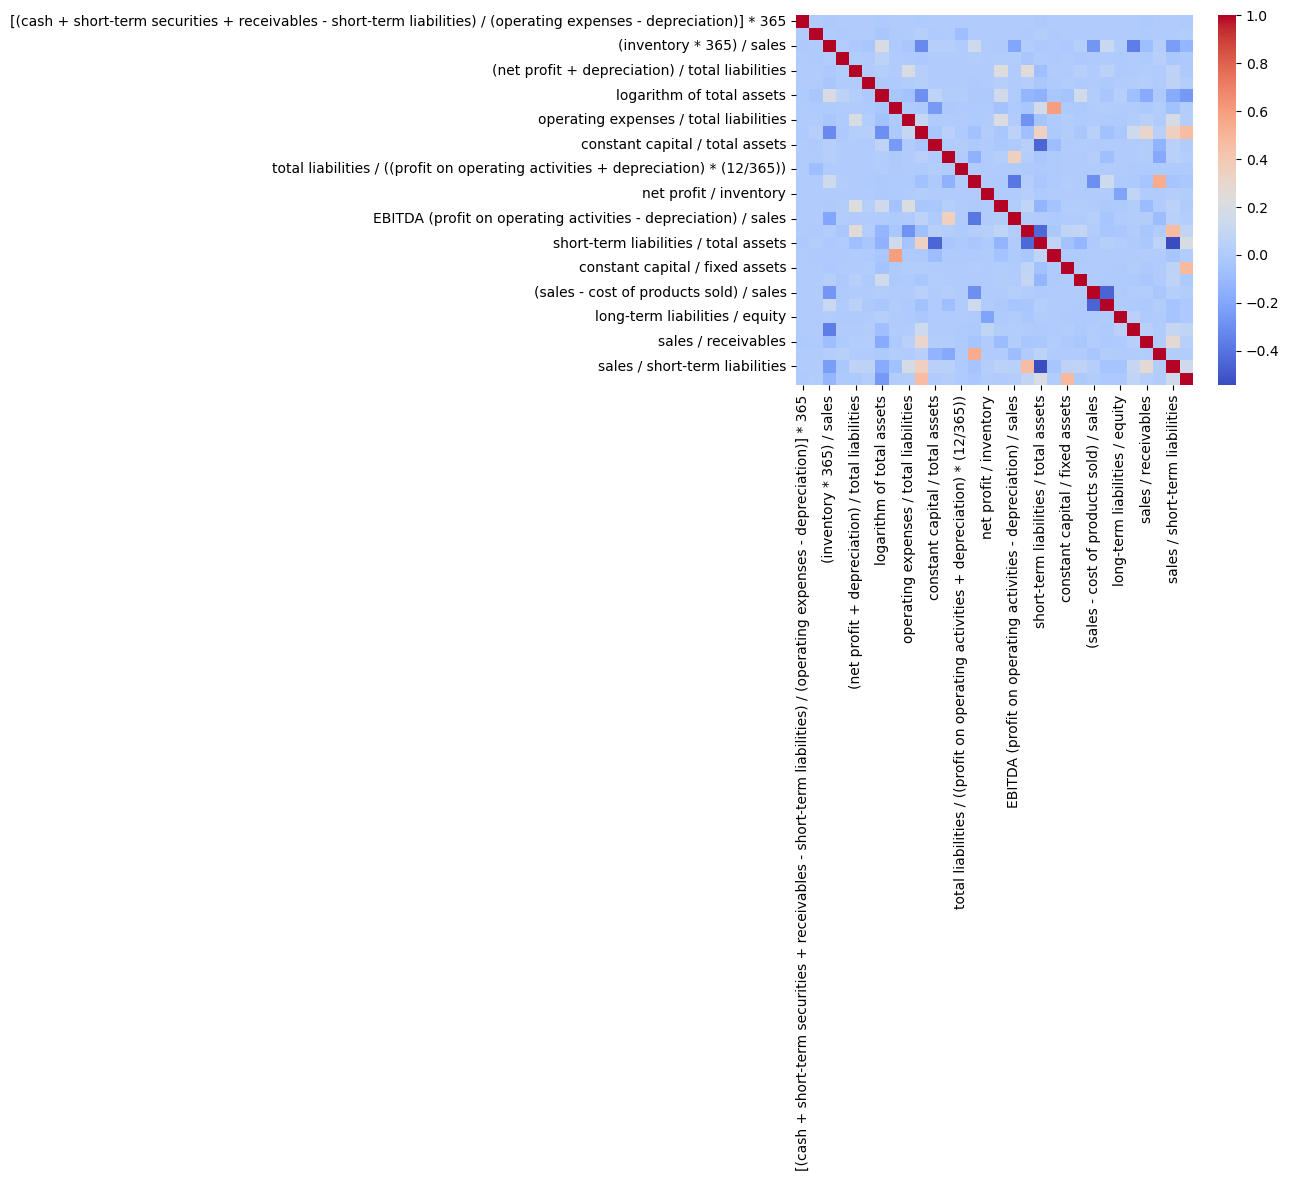

In [ ]:
# We use the pre-processing function 'process1' to get the feature space where no feature pair has a correlation value higher than 0.7.
df_graph = df_graph = df.copy()
X_heatmap, y_heatmap = process1(df_graph)
sns.heatmap(X_heatmap.corr(), annot=False, cmap="coolwarm")

## 2. Filter Method for Feature Selection

Filter method is a feature selection method in the preprocessing step, and it is independent of the machine learning algorithm deployed afterwards. In our case, we implemented two filtering method, based on Information Gain (IG) and Correlation respectively.

1. **Information Gain (IG)**: This method measures the reduction in entropy from transforming a dataset in some way. It is often used in training decision trees. Information Gain can be applied to feature selection by evaluating the mutual information between each feature and the target variable. Features that have higher mutual information with the target variable are considered more informative and are thus selected.

2. **Correlation**: This is a statistical measure that describes the size and direction of a relationship between variables. In feature selection, we often look for features that have a high correlation with the target variable but are not highly correlated with each other, to avoid redundancy.

For both functions, we sort the features based on their scores in descending order. Higher scores indicate more important features.

For better judging the optimal number of feature, we define a function `plot_feature_performance` to evaluate the performance of a model (balaneced Random Forest as example) as we vary the number of top features used. Finally, it plots the performance metrics f1 and recall (explained in the next chapter) against the number of features. With the aid of the plot, we determine the point of diminishing return through elbow method, selecting the optimal number of features.


In [ ]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import cross_val_score


def information_gain(X, y):
    mi_scores = mutual_info_classif(X, y, discrete_features="auto")
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def correlation_selection(X, y):
    if isinstance(y, pd.Series):
        y = y.to_frame(name="Target")
    elif isinstance(y, pd.DataFrame):
        y.columns = ["Target"]

    df_combined = pd.concat([X, y], axis=1)
    correlation_matrix = df_combined.corr()
    correlation_w_target = correlation_matrix["Target"].drop("Target")
    return correlation_w_target.abs().sort_values(ascending=False)


def plot_feature_performance(X, y, score_series, model, max_features=None):
    f1_results = []
    recall_results = []
    feature_counts = []

    if not max_features:
        max_features = len(score_series)

    for i in range(1, max_features + 1):
        top_features = score_series.nlargest(i).index
        X_selected = X[top_features]

        # Cross-validation F1 and recall scores
        f1 = cross_val_score(model, X_selected, y, cv=5, scoring="f1")
        recall = cross_val_score(model, X_selected, y, cv=5, scoring="recall")

        f1_results.append(f1.mean())
        recall_results.append(recall.mean())
        feature_counts.append(i)

    # Plotting the F1-score and recall results
    plt.figure(figsize=(10, 6))
    plt.plot(
        feature_counts,
        f1_results,
        marker="o",
        linestyle="-",
        markersize=8,
        label="F1 Score",
    )
    plt.plot(
        feature_counts,
        recall_results,
        marker="o",
        linestyle="-",
        markersize=8,
        label="Recall",
    )
    plt.xlabel("Number of Features")
    plt.ylabel("Score")
    plt.title("Model Performance vs. Number of Features")
    plt.legend()
    plt.grid(True)
    plt.show()

## 3. Wrapper Method for Feature Selection

The wrapper method for feature selection is a technique used to identify the most significant features for a predictive model. It works by starting with an empty set and adding features one by one, each time choosing the feature that, when added, most improves the model's F1 score - our desirable metric. This approach is iterative and selects features based on their contribution to the model's predictive accuracy.

In [ ]:
from sklearn.metrics import f1_score


def forward_feature_selection(model, X_train, y_train, X_test, y_test):
    selected_features = []
    best_f1 = 0
    features = list(X_train.columns)

    for _ in range(len(features)):
        f1_scores = []
        for feature in features:
            if feature not in selected_features:
                temp_features = selected_features + [feature]
                model.fit(X_train[temp_features], y_train)
                y_pred = model.predict(X_test[temp_features])
                f1 = f1_score(y_test, y_pred)
                f1_scores.append((feature, f1))

        # Find the best feature and its f1 score
        f1_scores.sort(key=lambda x: x[1], reverse=True)
        best_feature, best_feature_f1 = f1_scores[0]

        if best_feature_f1 > best_f1:
            print(f"Adding {best_feature} improved F1 to {best_feature_f1}")
            best_f1 = best_feature_f1
            selected_features.append(best_feature)
        else:
            break

    print("Selected features:", selected_features)
    return selected_features